In [1]:
from photutils.segmentation import (SourceCatalog, deblend_sources, detect_sources, detect_threshold)
from astropy.io import fits
from matplotlib import pyplot as plt
import numpy as np

In [2]:
def detection(fit,nsigma=5,npixels=50):
    """Función para extraer los datos y el header de la imagen y hacer la detección de fuentes
    con Photutils"""
    data=fits.open(f"{fit}")[0].data
    header=fits.open(f"{fit}")[0].header
    threshold=detect_threshold(data, nsigma)
    source_list=detect_sources(data, threshold, npixels)
    return source_list, data, header

In [3]:
def calibration(fit, reference, nsigma=5, npixels=50):
    """Función para hacer la calibración fotométrica en un fits específico, 
    necesita la magnitud de referencia correspondiente al filtro para calcular el zeropoint"""
    sources, data, header=detection(fit,nsigma,npixels)
    #Se genera el catálogo y se pasa a tabla
    cat=SourceCatalog(data, sources)
    tbl=cat.to_table()
    
    #Filtramos las columnas que necesitamos y dividimos el flujo por el
    #tiempo de exposición
    tabla=tbl['label', 'xcentroid', 'ycentroid', 'area', 'segment_flux']
    tabla['segment_flux'] = tabla['segment_flux']/header['EXPTIME']
    
    #Buscamos nuestra fuente a calibrar (en este caso por tamaño) y 
    #obtenemos su flujo
    estrella_index=np.argmax(tabla['area'])
    flux_estrella=tabla['segment_flux'][estrella_index]
    
    #Calculamos la magnitud medida y el zeropoint,
    #finalmente obtenemos las magnitudes calibradas para este fits
    mag_medida=-2.5*np.log(flux_estrella)
    zeropoint = reference - mag_medida
    tabla['magnitude'] = zeropoint - 2.5*np.log(tabla['segment_flux'])
    return tabla

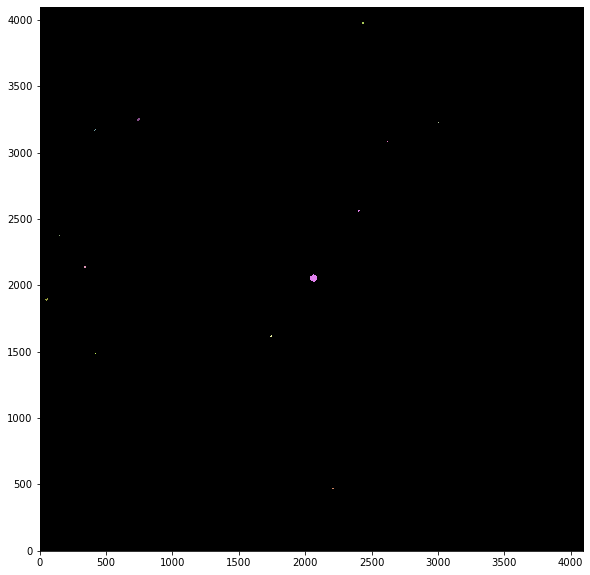

In [7]:
#Gráficas
sour,data,header=detection("HIP_64951_V_2.000secs_00001043.fit")
cmap_sour = sour.make_cmap(seed=123)
fig, ax = plt.subplots(1, 1, figsize=(10,10))
ax.imshow(sour, origin='lower', cmap=cmap_sour, interpolation='nearest')
plt.show()

In [4]:
#Ejemplo
tbl= calibration("HIP_64951_V_2.000secs_00001043.fit", 7)

In [5]:
tbl

label,xcentroid,ycentroid,area,segment_flux,magnitude
,,,pix2,,
int64,float64,float64,float64,float64,float64
1,2204.489076026147,467.6627407102055,136.0,8490.5,19.649046398220776
2,414.0171685332976,1484.8267051170276,122.0,7455.5,19.974036089109262
3,1738.325727683422,1618.4944244295762,138.0,8743.5,19.575639708802385
4,50.89545454545454,1892.0685002895193,247.0,17270.0,17.873988896334858
5,2058.1370585833997,2055.0689134004033,2316.0,1337512.0,6.999999999999993
6,335.88551080754655,2136.640289867144,183.0,12005.5,18.783003931434592
7,147.03842703349284,2375.0459031100477,55.0,3344.0,21.97849688867519
8,2398.8178085040026,2561.219617423849,150.0,9619.0,19.337065353805126
